# Recursive Forecasting with machine learning

[Forecasting with Machine Learning - Course](https://www.trainindata.com/p/forecasting-with-machine-learning)

In this notebook, we carry out **recursive forecasting** to predict multiple steps into the future by using gradient boosting machines for regression.

SKForecast produces lags out of the box. But we can combine SKForecast with Feature-engine and other libraries to create more features.

In [76]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

from skforecast.recursive import ForecasterRecursive
from skforecast.preprocessing import RollingFeatures

# Load data

We will use the electricity demand dataset found [here](https://github.com/tidyverts/tsibbledata/tree/master/data-raw/vic_elec/VIC2015).

**Citation:**

Godahewa, Rakshitha, Bergmeir, Christoph, Webb, Geoff, Hyndman, Rob, & Montero-Manso, Pablo. (2021). Australian Electricity Demand Dataset (Version 1) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.4659727

**Description of data:**

A description of the data can be found [here](https://rdrr.io/cran/tsibbledata/man/vic_elec.html). The data contains electricity demand in Victoria, Australia, at 30 minute intervals over a period of 12 years, from 2002 to early 2015. There is also the temperature in Melbourne at 30 minute intervals and public holiday dates.

In [77]:
# Electricity demand.
url = "https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/VIC2015/demand.csv"
df = pd.read_csv(url)

df.drop(columns=["Industrial"], inplace=True)

# Convert the integer Date to an actual date with datetime type
df["date"] = df["Date"].apply(
    lambda x: pd.Timestamp("1899-12-30") + pd.Timedelta(x, unit="days")
)

# Create a timestamp from the integer Period representing 30 minute intervals
df["date_time"] = df["date"] + \
    pd.to_timedelta((df["Period"] - 1) * 30, unit="m")

df.dropna(inplace=True)

# Rename columns
df = df[["date_time", "OperationalLessIndustrial"]]

df.columns = ["date_time", "demand"]

# Resample to hourly
df = (
    df.set_index("date_time")
    .resample("h")
    .agg({"demand": "sum"})
)

df.head()

,demand
date_time,
2002-01-01 00:00:00,6919.366092
2002-01-01 01:00:00,7165.974188
2002-01-01 02:00:00,6406.542994
2002-01-01 03:00:00,5815.537828
2002-01-01 04:00:00,5497.732922


In [78]:
df.tail()

,demand
date_time,
2015-02-28 19:00:00,9596.777060
2015-02-28 20:00:00,8883.230296
2015-02-28 21:00:00,8320.260550
2015-02-28 22:00:00,8110.055916
2015-02-28 23:00:00,8519.368752


In [79]:
# Split into train and test

# We leave the last February in the test set

end_train = '2014-12-31 23:59:59'
X_train = df.loc[:end_train]
X_test  = df.loc[end_train:]

## Plot time series

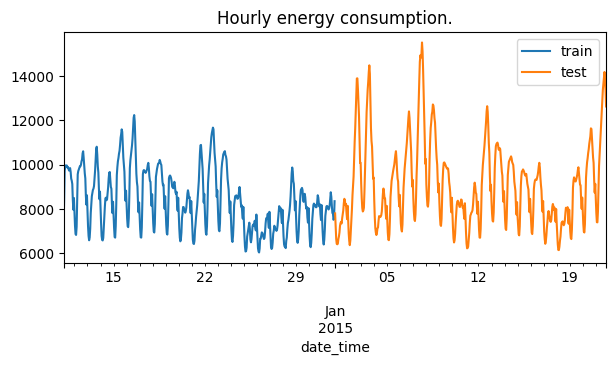

In [80]:
fig, ax = plt.subplots(figsize=(7, 3))
X_train.tail(500).plot(ax=ax)
X_test.head(500).plot(ax=ax)
ax.set_title('Hourly energy consumption.')
ax.legend(["train", "test"])
plt.show()

## Regression model

In [81]:
model = GradientBoostingRegressor(random_state=9, max_depth=3) 

## Window features

To add window features we need to create a function that creates those features.

We see the 10 lags and the 2 averages.

In [82]:
rolling = RollingFeatures(
    stats        = ['mean', 'mean'],
    window_sizes = [3, 24]
)

## Recursive forecaster

In [83]:
forecaster = ForecasterRecursive(
    regressor       = model,
    lags            = 10,
    window_features = rolling
)

In [84]:
# train the forecaster

forecaster.fit(
    y=X_train["demand"], # the series for the lags
)

forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: GradientBoostingRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Window features: ['roll_mean_3', 'roll_mean_24'] 
Window size: 24 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2002-01-01 00:00:00'), Timestamp('2014-12-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: 
    {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None,
    'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3,
    'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf':
    0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 9,
    'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-02-05 04:23:50 
Last fit date: 2025-02-05 04:24:41 
Skforecast version: 0.14.0 
Python version: 3.12.6 
Forecaster id: None

## Input features to regression

Be mindful to pass exactly the same data (y and exog if any) that you passed to fit. Otherwise, it will return something different!!!

In [85]:
# return the data that was used to train the model

X_tmp, y_tmp = forecaster.create_train_X_y(
    y=X_train["demand"],
)

X_tmp.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,roll_mean_3,roll_mean_24
date_time,,,,,,,,,,,,
2002-01-02 00:00:00,6863.872344,6015.750184,6255.765294,6628.839522,6509.902582,6400.844422,6527.011842,6490.669762,6221.417302,6013.496578,6378.462607,6172.564058
2002-01-02 01:00:00,6579.219880,6863.872344,6015.750184,6255.765294,6628.839522,6509.902582,6400.844422,6527.011842,6490.669762,6221.417302,6486.280803,6158.391299
2002-01-02 02:00:00,6990.826420,6579.219880,6863.872344,6015.750184,6255.765294,6628.839522,6509.902582,6400.844422,6527.011842,6490.669762,6811.306215,6151.093475
2002-01-02 03:00:00,6382.915018,6990.826420,6579.219880,6863.872344,6015.750184,6255.765294,6628.839522,6509.902582,6400.844422,6527.011842,6650.987106,6150.108976
2002-01-02 04:00:00,5896.928138,6382.915018,6990.826420,6579.219880,6863.872344,6015.750184,6255.765294,6628.839522,6509.902582,6400.844422,6423.556525,6153.500239


In [86]:
y_tmp.head()

date_time
2002-01-02 00:00:00    6579.219880
2002-01-02 01:00:00    6990.826420
2002-01-02 02:00:00    6382.915018
2002-01-02 03:00:00    5896.928138
2002-01-02 04:00:00    5853.937140
Freq: h, Name: y, dtype: float64

In [87]:
# double check that the windows are well calculated 
# and well placed

(6255.765294 + 6015.750184 + 6863.872344) / 3

6378.462607333334

In [88]:
# to undestand what's going on, let's plot
# the values of y a few times before the start
# of the train set

X_train.loc["2002-01-01 21:00:00":].head(10)

,demand
date_time,
2002-01-01 21:00:00,6255.765294
2002-01-01 22:00:00,6015.750184
2002-01-01 23:00:00,6863.872344
2002-01-02 00:00:00,6579.219880
2002-01-02 01:00:00,6990.826420
2002-01-02 02:00:00,6382.915018
2002-01-02 03:00:00,5896.928138
2002-01-02 04:00:00,5853.937140
2002-01-02 05:00:00,6344.834628


## Predict future data

We'll start by predicting the 24 hs right after the train set ends.

In [89]:
preds = forecaster.predict(
    steps=24,
)

preds

2015-01-01 00:00:00    8716.310518
2015-01-01 01:00:00    9335.848960
2015-01-01 02:00:00    9348.957374
2015-01-01 03:00:00    9237.150705
2015-01-01 04:00:00    9038.490323
2015-01-01 05:00:00    8871.650168
2015-01-01 06:00:00    8707.099717
2015-01-01 07:00:00    8623.982482
2015-01-01 08:00:00    8500.484161
2015-01-01 09:00:00    8330.808313
2015-01-01 10:00:00    8129.938562
2015-01-01 11:00:00    7959.521815
2015-01-01 12:00:00    7855.850858
2015-01-01 13:00:00    7746.445483
2015-01-01 14:00:00    7719.387610
2015-01-01 15:00:00    7681.334430
2015-01-01 16:00:00    7658.636905
2015-01-01 17:00:00    7673.242245
2015-01-01 18:00:00    7722.505907
2015-01-01 19:00:00    7813.867949
2015-01-01 20:00:00    7813.867949
2015-01-01 21:00:00    7774.244843
2015-01-01 22:00:00    7727.645388
2015-01-01 23:00:00    7744.306890
Freq: h, Name: pred, dtype: float64

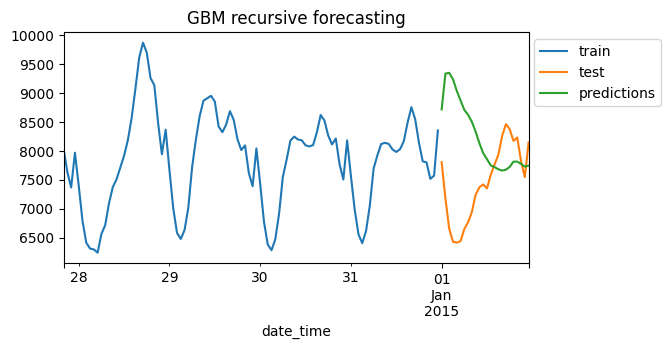

In [90]:
# Plot the forecast vs the actual

fig, ax = plt.subplots(figsize=(6, 3))
X_train.tail(100)["demand"].plot(ax=ax, label='train')
X_test.head(24)["demand"].plot(ax=ax, label='test')
preds.plot(ax=ax, label='predictions')
plt.title("GBM recursive forecasting")
ax.legend(bbox_to_anchor=(1.3, 1.0));

The model is not great, that much we can say!

In [91]:
# Prediction error

error_mse = mean_squared_error(
                y_true = X_test["demand"].head(24),
                y_pred = preds
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 1994653.8839085754


In [92]:
# Prediction error

error_rmse = root_mean_squared_error(
                y_true = X_test["demand"].head(24),
                y_pred = preds,
            )

print(f"Test error (rmse): {error_rmse}")

Test error (rmse): 1412.3221600996621


In [93]:
# one way of getting the importance

forecaster.get_feature_importances()

,feature,importance
0,lag_1,0.948629
2,lag_3,0.025640
11,roll_mean_24,0.005247
7,lag_8,0.004806
1,lag_2,0.004383
9,lag_10,0.004380
3,lag_4,0.002005
4,lag_5,0.001578
8,lag_9,0.001125
6,lag_7,0.001117


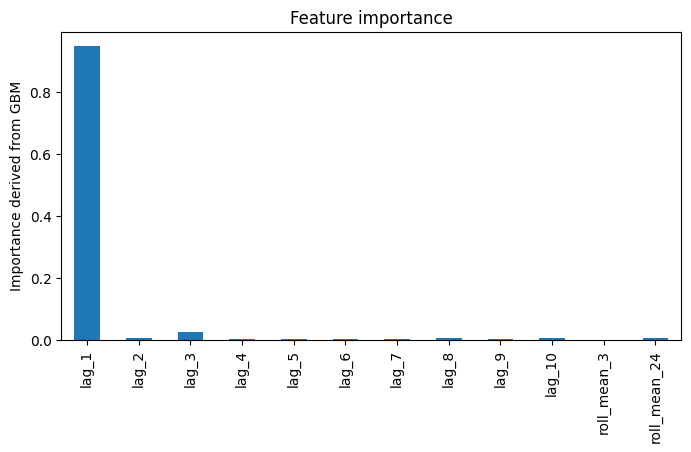

In [94]:
# another way of getting the importance

pd.Series(forecaster.regressor.feature_importances_,
          index=forecaster.regressor.feature_names_in_).plot.bar(figsize=(8,4))
plt.title('Feature importance')
plt.ylabel('Importance derived from GBM')
plt.show()

## Predict any time point in the future

In [95]:
# Say we want to predict energy demand for 1st of February

forecast_start = '2015-02-01 00:00:00'

# we need the energy demand up to 24 hs before that point
past_data_available = X_test[:'2015-01-31 23:59:59'].tail(24)

past_data_available.head()

,demand
date_time,
2015-01-31 00:00:00,7844.738566
2015-01-31 01:00:00,7164.501132
2015-01-31 02:00:00,6689.463174
2015-01-31 03:00:00,6553.640100
2015-01-31 04:00:00,6691.974048


In [96]:
predictions = forecaster.predict(
    steps=24,
    last_window=past_data_available["demand"],
)

predictions.head()

2015-02-01 00:00:00    8393.850953
2015-02-01 01:00:00    8705.458359
2015-02-01 02:00:00    8574.831323
2015-02-01 03:00:00    8371.325295
2015-02-01 04:00:00    8174.024397
Freq: h, Name: pred, dtype: float64

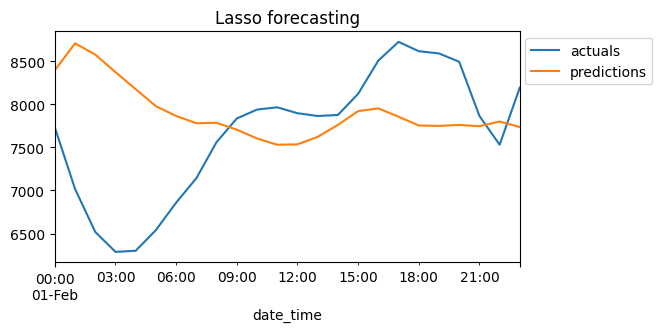

In [97]:
# Plot the forecast vs the actual

fig, ax = plt.subplots(figsize=(6, 3))
X_test['2015-01-31 23:59:59':]["demand"].head(24).plot(ax=ax, label='actuals')
predictions.plot(ax=ax, label='predictions')
plt.title("Lasso forecasting")
ax.legend(bbox_to_anchor=(1.3, 1.0));

In [98]:
# Prediction error

error_mse = mean_squared_error(
                y_true = X_test['2015-01-31 23:59:59':]["demand"].head(24),
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 950002.3288374892


In [99]:
# Prediction error

error_rmse = root_mean_squared_error(
                y_true = X_test["demand"].head(24),
                y_pred = preds,
            )

print(f"Test error (rmse): {error_rmse}")

Test error (rmse): 1412.3221600996621


That's it! Now you know how you can add window features if you are using recursive forecasting with skforecast.